In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

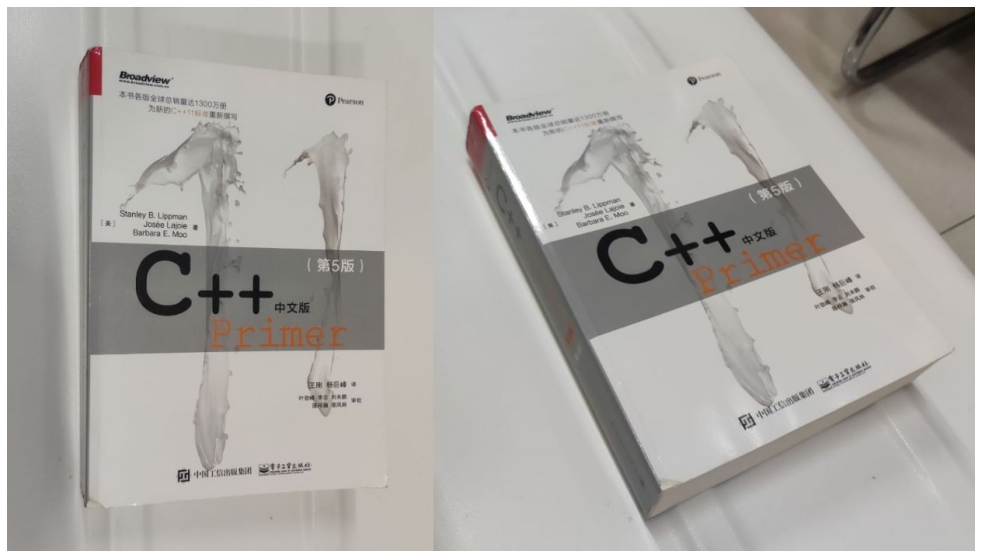

In [5]:
# 读取图片
fst = r"image\example1\1.jpg"
scd = r"image\example1\2.jpg"
path1, path2 = [fst, scd]

im1 = cv2.imread(path1)
im2 = cv2.imread(path2)

# 计算SURF特征点和对应的描述子，kp存储特征点坐标，des存储对应描述子
surf = cv2.SIFT_create()
kp1, des1 = surf.detectAndCompute(im1, None)
kp2, des2 = surf.detectAndCompute(im2, None)

# 显示初始图像
im3 = np.concatenate((im1, im2), axis = 1)
fig = plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show

<H3>一. 手动计算单应性矩阵

In [7]:
# 手动添加匹配点对
matchesA = [((112, 51), (54, 130)),
           ((487, 96), (376, 62)),
           ((100, 645), (293, 623)),
           ((488, 618), (670, 400))]

# 构建其次坐标矩阵
A = []
for match in matchesA:
    x1, y1 = match[0]
    x2, y2 = match[1]
    A.append([-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2])
    A.append([0, 0, 0, -x1, -y1, -1, x1*y2, y1*y2, y2])

# 奇异值分解
A = np.asarray(A)
_, _, V = np.linalg.svd(A)

# 归一化
HA = V[-1, :].reshape((3, 3))
HA /= HA[2, 2]
print("手动计算Homography矩阵:\n",HA)

手动计算Homography矩阵:
 [[ 9.24593067e-01  2.70544133e-01 -6.29288546e+01]
 [-2.28260772e-01  5.05167784e-01  1.30820753e+02]
 [ 3.05962431e-04 -5.18206636e-04  1.00000000e+00]]


<function matplotlib.pyplot.show(close=None, block=None)>

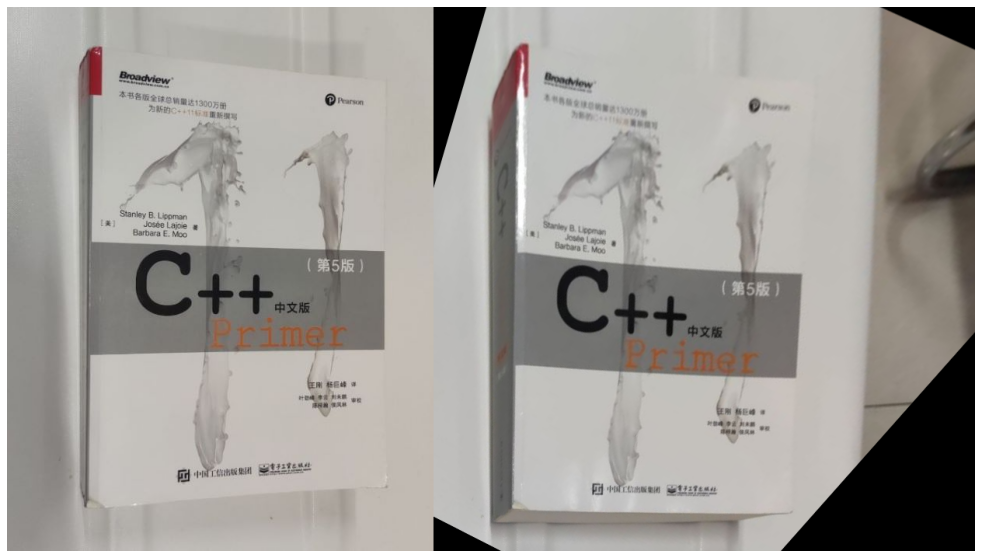

In [8]:
# 获取图像 im2 的高度、宽度和通道数
h, w, d = im2.shape

# 应用透视变换
HA_inv = np.linalg.inv(HA)
imgt2 = cv2.warpPerspective(im2, HA_inv, (w, h))
imgt4 = np.concatenate((im1, imgt2), axis = 1)

# 显示变换后的图像
fig = plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(imgt4, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show

<h3>二. SURF特征点计算单应性矩阵

In [9]:
# 匹配特征点描述子
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
print("SIFT特征点匹配个数：", len(matches))

SIFT特征点匹配个数： 670


In [10]:
# 提取匹配较好的特征点
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

print("筛选特征点匹配个数：", len(good))

筛选特征点匹配个数： 92


In [115]:
# 计算单应性矩阵
# cv.findHomography中使用了RANSAC算法剔除错误匹配
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

correct_matches = sum(matchesMask)
print("RANSAC剔除错误匹配后的特征点匹配个数:", correct_matches)
print("SURF特征匹配的Homography矩阵:\n",H)

RANSAC剔除错误匹配后的特征点匹配个数: 76
Homography矩阵:
 [[ 8.75644853e-01  2.96257287e-01 -6.08333197e+01]
 [-2.30707673e-01  5.71026679e-01  1.26979245e+02]
 [ 1.52090654e-04 -4.13787526e-04  1.00000000e+00]]


<function matplotlib.pyplot.show(close=None, block=None)>

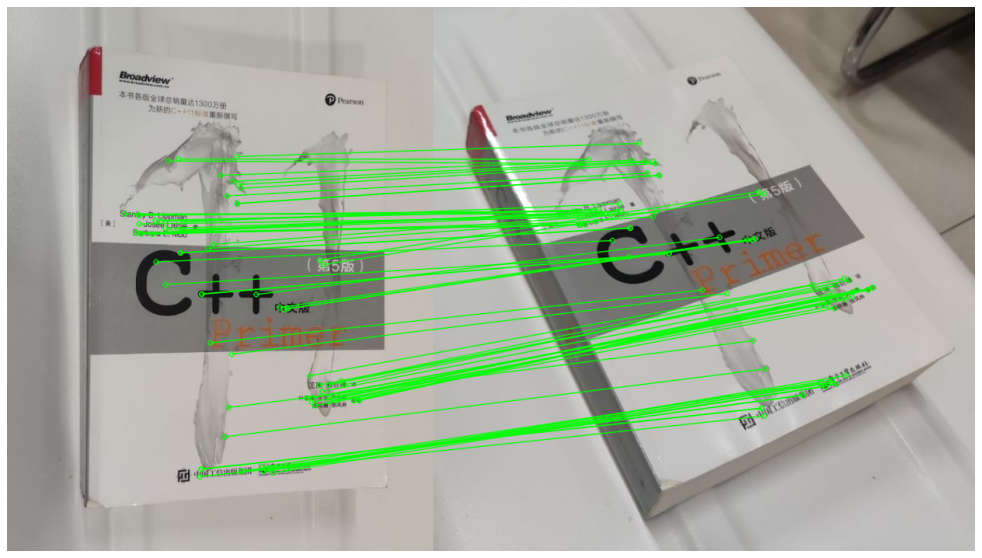

In [116]:
# 显示特征匹配图
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(im1, kp1, im2, kp2, good, None, **draw_params)
fig = plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

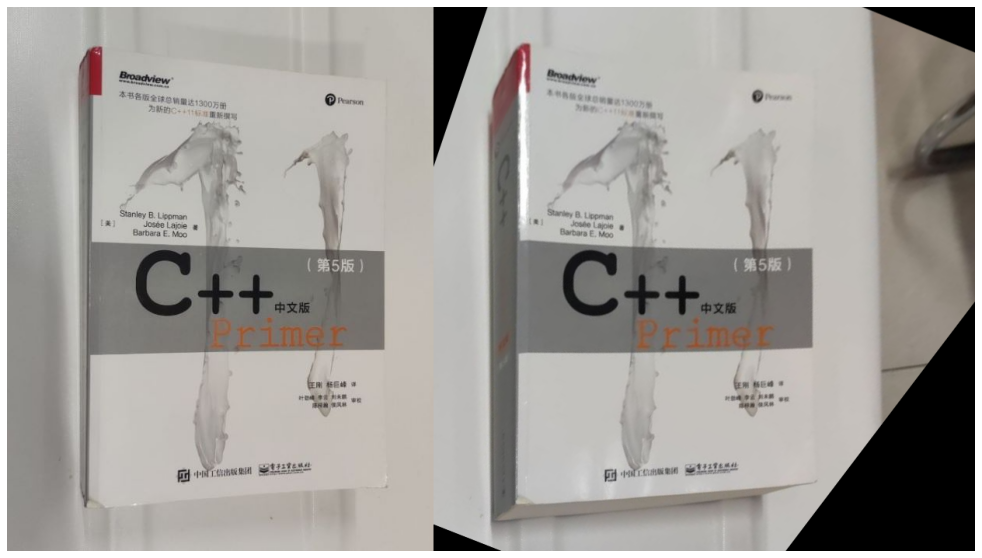

In [117]:
# 获取图像 im2 的高度、宽度和通道数
h, w, d = im2.shape

# 应用透视变换
H_inv = np.linalg.inv(H)
img2 = cv2.warpPerspective(im2, H_inv, (w, h))
img4 = np.concatenate((im1, img2), axis = 1)

# 显示变换后的图像
fig = plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show